In [56]:
## libraries
import os
from dotenv import load_dotenv
import psycopg2
import psycopg2.extras as extras
import pandas as pd
import numpy as np

## visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

## ML Libraries
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

## utilities
import feature_extraction
import weather_api

import warnings
warnings.filterwarnings("ignore")


## Settings
### Tunahanın ev
lat = 36.929517
lon = 30.663494

In [2]:
## DB Insert function
def execute_values(conn, df, table):

    tuples = [tuple(x) for x in df.to_numpy()]

    cols = ','.join(list(df.columns))
    # SQL query to execute
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("the dataframe is inserted")
    cursor.close()


In [3]:
# load .env file
load_dotenv()

DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "name": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD")
}

connection = psycopg2.connect(
            database=DB_CONFIG["name"],
            user=DB_CONFIG["user"],
            password=DB_CONFIG["password"],
            host=DB_CONFIG["host"],
            port=DB_CONFIG["port"]
        )

## Query data from the database
data = pd.read_sql("SELECT * FROM public.weather_data_0001", connection)

In [4]:
## Load future weather data
## Settings start and end date. Start today, end today + 3 days
start = data["timestamp"].dt.date.max()
end = start + pd.Timedelta(days=3)
start_str = start.strftime('%Y-%m-%d')
end_str = end.strftime('%Y-%m-%d')

## Fetch future weather data from the API
future = weather_api.fetch_weather_data(lat, lon, start_str, end_str)

In [6]:
data = data[["timestamp","temperature","humidity","wind_speed","wind_direction","pressure","solar_radiation"]].copy()
data = feature_extraction.feature_engineering(data,future_data = future, drop_columns=["id"], resample_freq="H")
data = feature_extraction.add_meteo_features(data)
data = feature_extraction.add_advanced_features_with_lags(data)
data = feature_extraction.generate_features(data)
data

Dropped columns: ['id']


,timestamp,temperature,humidity,wind_speed,wind_direction,pressure,solar_radiation,wd_rad,wind_u,wind_v,...,lag_humidity_24h,lag_pressure_1h,lag_pressure_12h,lag_pressure_24h,lag_wind_speed_1h,lag_wind_speed_12h,lag_wind_speed_24h,lag_solar_radiation_1h,lag_solar_radiation_12h,lag_solar_radiation_24h
0,2025-09-07 22:00:00+00:00,27.068000,71.356000,0.080000,278.520000,997.436000,0.0,4.861091,0.064225,-0.047698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-09-07 23:00:00+00:00,26.861667,71.695833,0.175000,255.366667,997.221667,0.0,4.456989,0.089978,-0.139839,...,NaN,997.436000,NaN,NaN,0.080000,NaN,NaN,0.0,NaN,NaN
2,2025-09-08 00:00:00+00:00,26.310000,72.752500,0.091667,277.875000,996.880000,0.0,4.849834,0.066852,-0.061346,...,NaN,997.221667,NaN,NaN,0.175000,NaN,NaN,0.0,NaN,NaN
3,2025-09-08 01:00:00+00:00,25.623333,73.805000,0.041667,314.616667,996.540833,0.0,5.491097,0.041636,0.001599,...,NaN,996.880000,NaN,NaN,0.091667,NaN,NaN,0.0,NaN,NaN
4,2025-09-08 02:00:00+00:00,25.606667,72.156667,0.000000,314.141667,995.999167,0.0,5.482806,0.000000,0.000000,...,NaN,996.540833,NaN,NaN,0.041667,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,2025-10-05 19:00:00+00:00,19.617001,78.000000,2.039608,348.690094,1003.219971,0.0,6.085790,2.000000,-0.399999,...,76.0,1003.352844,1006.425537,1004.845398,1.711724,2.773085,2.901724,0.0,294.0,0.0
670,2025-10-05 20:00:00+00:00,18.967001,77.000000,1.992486,342.474335,1002.996216,0.0,5.977305,1.899999,-0.600003,...,79.0,1003.219971,1006.087036,1004.938171,2.039608,2.158703,2.828427,0.0,468.0,0.0
671,2025-10-05 21:00:00+00:00,18.367001,76.000000,1.969772,336.037506,1002.773987,0.0,5.864961,1.800000,-0.800001,...,80.0,1002.996216,1005.732422,1004.833435,1.992486,1.004988,2.765863,0.0,571.0,0.0
672,2025-10-05 22:00:00+00:00,17.817001,74.000000,1.969772,336.037506,1002.455078,0.0,5.864961,1.800000,-0.800001,...,78.0,1002.773987,1005.178040,1004.829346,1.969772,0.538516,2.624881,0.0,623.0,0.0


In [ ]:
### Train - Test Split

## Get observed data
model_data = data[data.status == "observed"].copy()
model_data.drop(["status"], axis=1, inplace=True)

## Train set features
filter_columns = (
    model_data.columns.str.contains("delta") | 
    model_data.columns.str.contains("lag") | 
    model_data.columns.str.contains("sin") |
    model_data.columns.str.contains("cos") |
    model_data.columns.str.contains("roll") |
    model_data.columns.str.contains("hour") |
    model_data.columns.str.contains("month") |
    model_data.columns.str.contains("day") |
    model_data.columns.str.contains("timestamp") |
    model_data.columns.str.contains("temperature")
)

## Settings
train_size = int(len(model_data) * 0.90)
val_size = int(len(model_data) * 0.05)

## Split
train = model_data[:train_size]
train = train.loc[:,filter_columns]
val = model_data[train_size:train_size + val_size]
val = val.loc[:,filter_columns]
test = model_data[train_size + val_size:]
test = test.loc[:,filter_columns]


X_train = train.drop(["timestamp","temperature"],axis=1)
y_train = train["temperature"]

X_valid = val.drop(["timestamp","temperature"],axis=1)
y_valid = val["temperature"]

X_test = test.drop(["timestamp","temperature"],axis=1)
y_test = test["temperature"]

## useless columns

## Check size
print("Train set size : ",X_train.shape[0]," row, ",X_train.shape[1]," column.")
print("Validation set size : ",X_valid.shape[0]," row, ",X_valid.shape[1]," column.")
print("Test set size : ",X_test.shape[0]," row, ",X_test.shape[1]," column.")

Train set size :  537  row,  60  column.
Validation set size :  29  row,  60  column.
Test set size :  31  row,  60  column.


0:	learn: 2.5149242	test: 2.8488577	best: 2.8488577 (0)	total: 29.1ms	remaining: 5.8s
100:	learn: 0.0439073	test: 0.6485708	best: 0.6478040 (84)	total: 3.68s	remaining: 3.61s
199:	learn: 0.0054882	test: 0.6529151	best: 0.6457976 (114)	total: 7.28s	remaining: 0us

bestTest = 0.6457976165
bestIteration = 114

Shrink model to first 115 iterations.
Validation MAE: 0.52
Validation RMSE: 0.65
Test MAE: 1.17
Test RMSE: 1.29


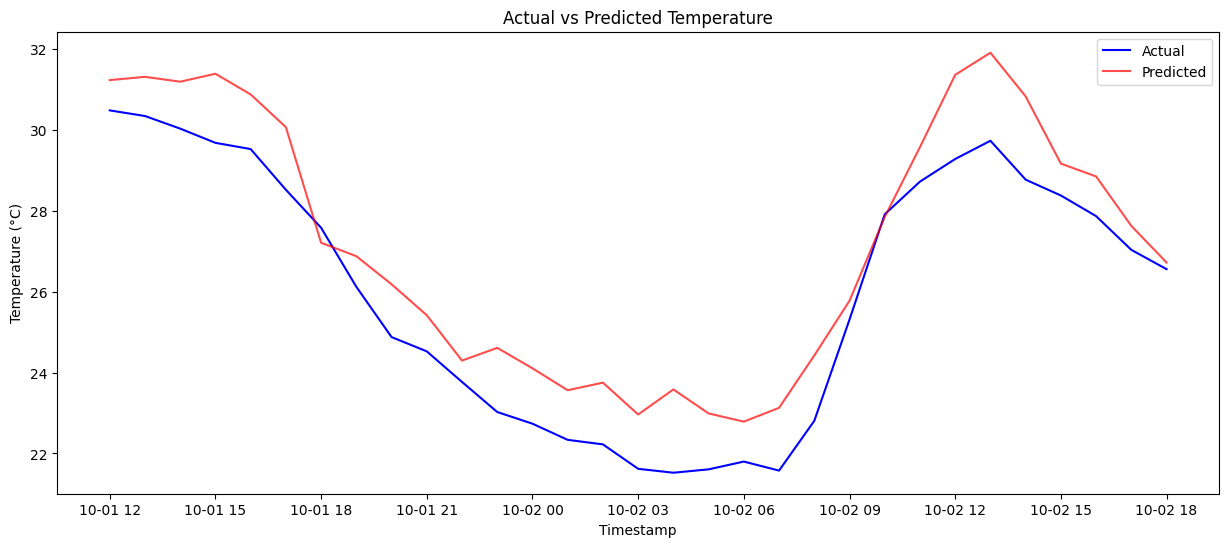

In [14]:
## Catboost regressor model and validation

cat_features = ['hour', 'day', 'month']

model = CatBoostRegressor(learning_rate = 0.4,iterations = 200,verbose=100)
model.fit(X_train, y_train, eval_set = (X_valid, y_valid), cat_features = cat_features)

## Validation
y_pred = model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

### Results
print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

## Test Set
y_pred_test = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

### Results
print(f"Test MAE: {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")

plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], y_test, label='Actual', color='b')
plt.plot(test['timestamp'], y_pred_test, label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature')
plt.legend()

HGB Validation MAE: 0.26
HGB Validation RMSE: 0.36
HGB Test MAE: 0.44
HGB Test RMSE: 0.56


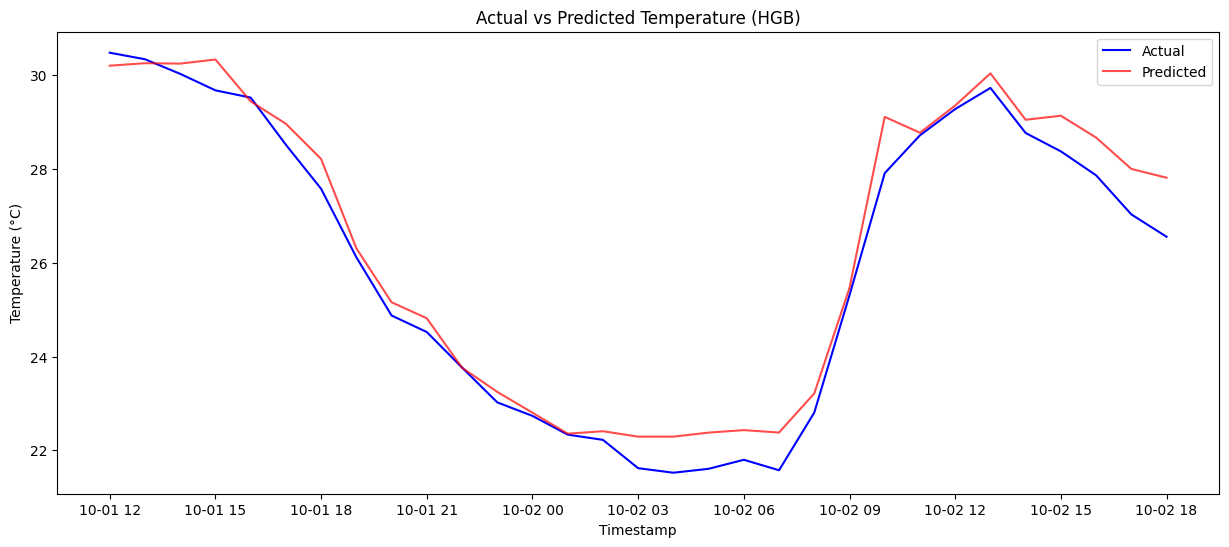

In [15]:
# Histogram gradient boosting regressor model and validation

hgb_model = HistGradientBoostingRegressor()
hgb_model.fit(X_train, y_train)

## Validation
hgb_y_pred = hgb_model.predict(X_valid)
hgb_mae = mean_absolute_error(y_valid, hgb_y_pred)
hgb_rmse = mean_squared_error(y_valid, hgb_y_pred, squared=False)

## Results
print(f"HGB Validation MAE: {hgb_mae:.2f}")
print(f"HGB Validation RMSE: {hgb_rmse:.2f}")

## Test set
y_pred_test = hgb_model.predict(X_test)
hgb_mae_test = mean_absolute_error(y_test, y_pred_test)
hgb_rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

## Results
print(f"HGB Test MAE: {hgb_mae_test:.2f}")
print(f"HGB Test RMSE: {hgb_rmse_test:.2f}")


## plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], y_test, label='Actual', color='b')
plt.plot(test['timestamp'], y_pred_test, label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature (HGB)')
plt.legend()
plt.show()

,delta_wind_direction_1h,delta_wind_direction_3h,delta_wind_direction_6h,hour,day,month,hour_sin,hour_cos,day_sin,day_cos,...,lag_pressure_1h,lag_pressure_12h,lag_pressure_24h,lag_wind_speed_1h,lag_wind_speed_12h,lag_wind_speed_24h,lag_solar_radiation_1h,lag_solar_radiation_12h,lag_solar_radiation_24h,temperature
24,36.575641,-4.599359,132.067308,22,8,9,-0.500000,8.660254e-01,0.998717,-0.050649,...,997.348333,996.241667,997.436000,0.000000,0.191667,0.080000,0.0,77.510000,0.000000,26.269231
25,-56.192308,-48.391667,47.141667,23,8,9,-0.258819,9.659258e-01,0.998717,-0.050649,...,997.613077,996.021667,997.221667,0.146154,0.208333,0.175000,0.0,67.676667,0.000000,26.200000
26,20.291667,0.675000,11.908333,0,9,9,0.000000,1.000000e+00,0.968077,-0.250653,...,997.608333,995.891667,996.880000,0.150000,0.300000,0.091667,0.0,74.980000,0.000000,26.034167
27,-6.491667,-42.392308,-46.991667,1,9,9,0.258819,9.659258e-01,0.968077,-0.250653,...,997.631667,995.796667,996.540833,0.208333,0.216667,0.041667,0.0,68.186667,0.000000,25.589167
28,70.525000,84.325000,35.933333,2,9,9,0.500000,8.660254e-01,0.968077,-0.250653,...,997.592500,995.525833,995.999167,0.150000,0.041667,0.000000,0.0,76.786667,0.000000,24.964167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,106.033333,52.450000,20.889103,2,30,9,0.500000,8.660254e-01,-0.201299,0.979530,...,999.558333,1001.336923,1001.980833,0.375000,0.192308,0.250000,0.0,98.596923,0.000000,22.845000
533,-17.381410,69.993590,37.961538,3,30,9,0.707107,7.071068e-01,-0.201299,0.979530,...,999.669167,1000.736667,1001.858333,0.066667,0.100000,0.575000,0.0,107.875833,0.000000,22.575385
534,11.389744,100.041667,50.258333,4,30,9,0.866025,5.000000e-01,-0.201299,0.979530,...,999.493077,1000.245000,1001.740833,0.315385,0.075000,0.166667,0.0,59.565000,0.000000,22.449167
535,-18.925000,-24.916667,27.533333,5,30,9,0.965926,2.588190e-01,-0.201299,0.979530,...,999.209167,1000.175833,1001.895833,0.100000,0.050000,0.233333,0.0,23.534167,0.000000,22.287500


RF Validation MAE: 0.28
RF Validation RMSE: 0.37
RF Test MAE: 0.75
RF Test RMSE: 0.87


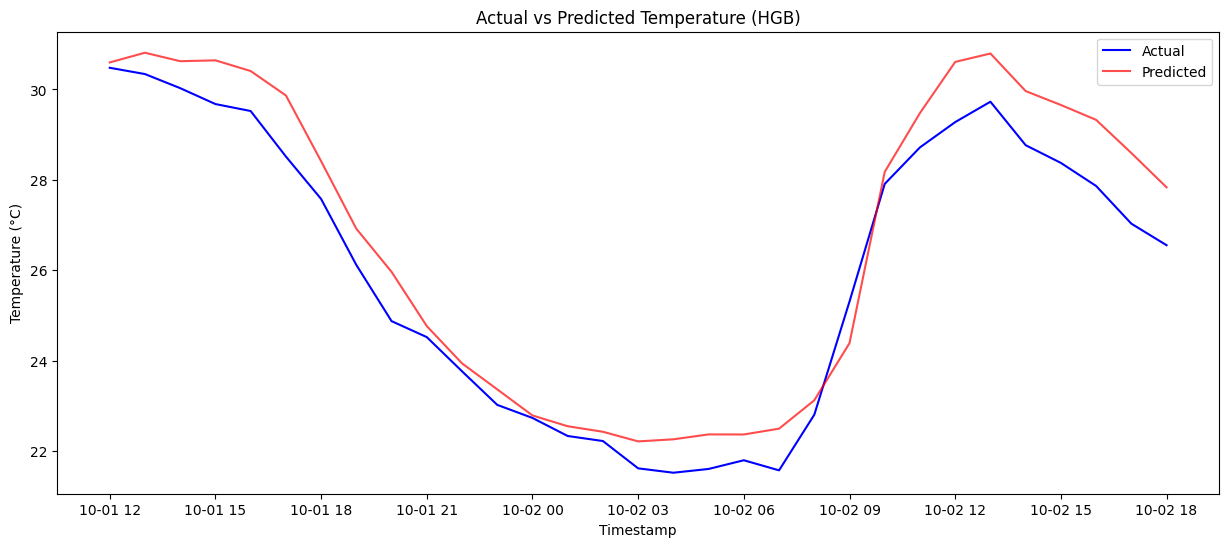

In [49]:
# Random Forest Regressor model and validation
## drop NA rows
X_train["temperature"] = y_train
X_train = X_train.dropna().reset_index(drop = True)
y_train = X_train["temperature"]
X_train = X_train.drop("temperature",axis = 1)

## Fit model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

## Validation
rf_y_pred = rf_model.predict(X_valid)
rf_mae = mean_absolute_error(y_valid, rf_y_pred)
rf_rmse = mean_squared_error(y_valid, rf_y_pred, squared=False)

## Results
print(f"RF Validation MAE: {rf_mae:.2f}")
print(f"RF Validation RMSE: {rf_rmse:.2f}")

## Test set
y_pred_test = rf_model.predict(X_test)
rf_mae_test = mean_absolute_error(y_test, y_pred_test)
rf_rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

## Results
print(f"RF Test MAE: {rf_mae_test:.2f}")
print(f"RF Test RMSE: {rf_rmse_test:.2f}")


## plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], y_test, label='Actual', color='b')
plt.plot(test['timestamp'], y_pred_test, label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature (HGB)')
plt.legend()
plt.show()

XGB Validation MAE: 0.33
XGB Validation RMSE: 0.44
XGB Test MAE: 0.58
XGB Test RMSE: 0.71


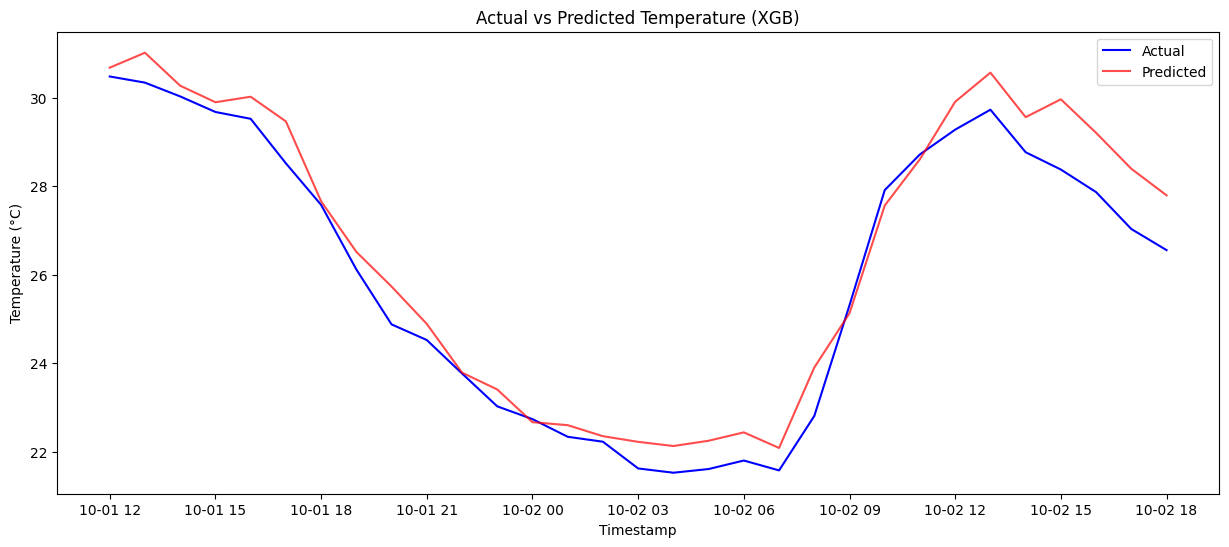

In [58]:
# XGBoostRegressor model and validation
## drop NA rows
X_train["temperature"] = y_train
X_train = X_train.dropna().reset_index(drop = True)
y_train = X_train["temperature"]
X_train = X_train.drop("temperature",axis = 1)

## Fit model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

## Validation
xgb_y_pred = xgb_model.predict(X_valid)
xgb_mae = mean_absolute_error(y_valid, xgb_y_pred)
xgb_rmse = mean_squared_error(y_valid, xgb_y_pred, squared=False)

## Results
print(f"XGB Validation MAE: {xgb_mae:.2f}")
print(f"XGB Validation RMSE: {xgb_rmse:.2f}")

## Test set
y_pred_test = xgb_model.predict(X_test)
xgb_mae_test = mean_absolute_error(y_test, y_pred_test)
xgb_rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

## Results
print(f"XGB Test MAE: {xgb_mae_test:.2f}")
print(f"XGB Test RMSE: {xgb_rmse_test:.2f}")


## plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], y_test, label='Actual', color='b')
plt.plot(test['timestamp'], y_pred_test, label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature (XGB)')
plt.legend()
plt.show()

In [28]:
## Create all data
all_data = model_data.loc[:,filter_columns]
train_all = all_data.drop(["timestamp","temperature"],axis = 1).copy()
y_all = all_data["temperature"]

## Future set
future_data = data[data.status == "api"].copy()

## future set features
filter_columns_future = (
    future_data.columns.str.contains("delta") | 
    future_data.columns.str.contains("lag") | 
    future_data.columns.str.contains("sin") |
    future_data.columns.str.contains("cos") |
    future_data.columns.str.contains("roll") |
    future_data.columns.str.contains("hour") |
    future_data.columns.str.contains("month") |
    future_data.columns.str.contains("day") |
    future_data.columns.str.contains("timestamp") |
    future_data.columns.str.contains("temperature")
)

future_all = future_data.loc[:,filter_columns_future]
future_all_ = future_all.drop(["timestamp","temperature"],axis = 1).copy()

In [30]:
## Catboost ~ Train model with all data
model.fit(train_all,y_all)

results_df = model.predict(future_all_)
results_df = pd.DataFrame(results_df, columns=['predicted_temperature'])
results_df["timestamp"] = future_all["timestamp"].values

0:	learn: 2.5241758	total: 23.1ms	remaining: 4.6s
100:	learn: 0.0444614	total: 627ms	remaining: 615ms
199:	learn: 0.0058989	total: 1.23s	remaining: 0us


In [35]:
## HGB Regressor ~ Train model with all data
hgb_model.fit(train_all,y_all)

results_df_hgb = hgb_model.predict(future_all_)
results_df_hgb = pd.DataFrame(results_df_hgb, columns=['predicted_temperature'])
results_df_hgb["timestamp"] = future_all["timestamp"].values

In [53]:
## RF Regressor ~ Train model with all data
## drop NA rows
train_all["temperature"] = y_all
train_all_rf = train_all.dropna().reset_index(drop = True)
y_all_rf = train_all_rf["temperature"]
train_all_rf = train_all_rf.drop("temperature",axis = 1)

rf_model.fit(train_all_rf,y_all_rf)

results_df_rf = rf_model.predict(future_all_)
results_df_rf = pd.DataFrame(results_df_rf, columns=['predicted_temperature'])
results_df_rf["timestamp"] = future_all["timestamp"].values

In [59]:
## XGB Regressor ~ Train model with all data
## drop NA rows
train_all["temperature"] = y_all
train_all_xgb = train_all.dropna().reset_index(drop = True)
y_all_xgb = train_all_xgb["temperature"]
train_all_xgb = train_all_xgb.drop("temperature",axis = 1)

xgb_model.fit(train_all_xgb,y_all_xgb)

results_df_xgb = xgb_model.predict(future_all_)
results_df_xgb = pd.DataFrame(results_df_xgb, columns=['predicted_temperature'])
results_df_xgb["timestamp"] = future_all["timestamp"].values

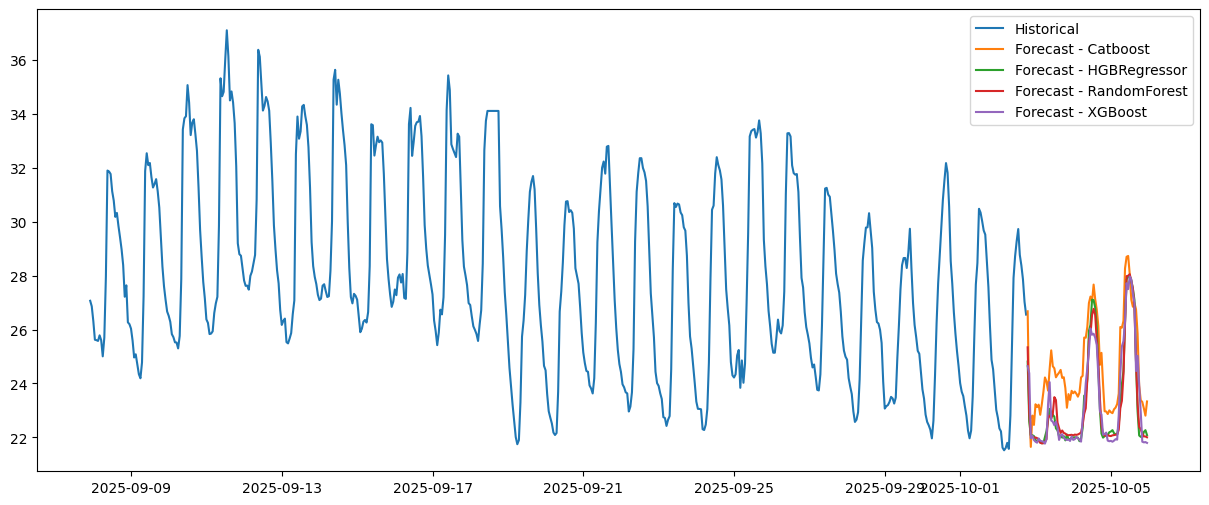

In [60]:
## plot predictions
plt.figure(figsize=(15,6))
plt.plot(all_data["timestamp"],all_data["temperature"],label = "Historical")
plt.plot(results_df["timestamp"],results_df["predicted_temperature"],label = "Forecast - Catboost")
plt.plot(results_df_hgb["timestamp"],results_df_hgb["predicted_temperature"],label = "Forecast - HGBRegressor")
plt.plot(results_df_rf["timestamp"],results_df_rf["predicted_temperature"],label = "Forecast - RandomForest")
plt.plot(results_df_xgb["timestamp"],results_df_xgb["predicted_temperature"],label = "Forecast - XGBoost")
plt.legend()
plt.show()

In [63]:
## Database insert
results_df["model"] = "Catboost"
results_df_hgb["model"] = "HistGradientBoosting"
results_df_rf["model"] = "RandomForest"
results_df_xgb["model"] = "XGBoost"
all_pred = pd.concat([results_df, results_df_hgb,results_df_rf,results_df_xgb], axis=0)
all_pred["device_id"] = "1"
all_pred.columns = ["predicted_temperature", "forecast_datetime", "model", "device_id"]

##
execute_values(conn=connection, df=all_pred[['model','forecast_datetime','predicted_temperature','device_id']], table='public.predictions')

the dataframe is inserted


In [ ]:
future = weather_api.fetch_weather_data(lat, lon, "2025-09-29", "2025-10-03")
future.columns = ['timestamp', 'temperature', 'humidity', 'wind_speed', 'wind_direction', 'pressure', 'solar_radiation']
future["status"] = "future"